# 爱奇艺弹幕数据分析

## 数据读入

In [1]:
# 导入库
import os  
import jieba
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from pyecharts.charts import Bar, Pie, Line, WordCloud, Page
from pyecharts import options as opts 
from pyecharts.globals import SymbolType, WarningType
WarningType.ShowWarning = False

In [5]:
# 读入数据
data_list = os.listdir('../data/')[:-1]

df_all = pd.DataFrame()

for i in data_list:
    df_one = pd.read_csv(f'../data/{i}', engine='python', encoding='utf-8', index_col=0)  
    df_all = df_all.append(df_one, ignore_index=False)
    print(df_one.shape) 

(27507, 6)
(15767, 6)
(12693, 6)
(13502, 6)
(17403, 6)
(17286, 6)
(11558, 6)
(22130, 6)
(13560, 6)
(14085, 6)
(17705, 6)
(17476, 6)


In [6]:
df_all.shape

(200672, 6)

## 数据预处理

In [7]:
# 重命名
rename_list = {
    '第一集': '第一集_暑假',
    '第二集': '第二集_警告',
    '第三集': '第三集_少年宫',
    '第四集': '第四集_交易',
    '第五集': '第五集_妈妈',
    '第六集': '第六集_苍蝇',
    '第七集': '第七集_日记',
    '第八集': '第八集_局外人',
    '第九集': '第九集_台风',
    '第十集': '第十集_张叔叔',
    '第十一集': '第十一集_燃烧',
    '第十二集': '第十二集_角落'
}

# 重命名
df_all['episodes'] = df_all['episodes'].str.strip().map(rename_list)
df_all.head() 

,episodes,name,contentId,content,showTime,likeCount
0,第一集_暑假,普普,1592838562920007156,二刷的朋友有吗,1,12
1,第一集_暑假,用户4ce9c103,1592308702474009744,良心啊，一小时,1,75
2,第一集_暑假,未知用户,1592317555873002245,基本都好,1,9
3,第一集_暑假,张东升,1593139392541001130,带你们去爬山,1,0
4,第一集_暑假,未知用户,1593076745193007217,一集一小时第一次遇见不错,1,0


In [8]:
def transform_name(x):
    if x=='张东升' or x=='朱朝阳' or x=='普普' or x=='严良' or x=='陈冠声' or x=='周春红' or x=='朱永平' or x=='叶军':
        return 'VIP用户'
    elif x=='未知用户':
        return '未知用户'
    else:
        return '普通用户'
    
df_all['name_level'] = df_all.name.str.strip().apply(transform_name)
df_all.head() 

,episodes,name,contentId,content,showTime,likeCount,name_level
0,第一集_暑假,普普,1592838562920007156,二刷的朋友有吗,1,12,VIP用户
1,第一集_暑假,用户4ce9c103,1592308702474009744,良心啊，一小时,1,75,普通用户
2,第一集_暑假,未知用户,1592317555873002245,基本都好,1,9,未知用户
3,第一集_暑假,张东升,1593139392541001130,带你们去爬山,1,0,VIP用户
4,第一集_暑假,未知用户,1593076745193007217,一集一小时第一次遇见不错,1,0,未知用户


## 数据可视化

### 弹幕发送人群等级分布

In [9]:
level_num = df_all.name_level.value_counts()
level_num 

未知用户     157722
VIP用户     41127
普通用户       1823
Name: name_level, dtype: int64

In [10]:
data_pair =  [list(z) for z in zip(level_num.index.tolist(), level_num.values.tolist())]

# 绘制饼图
pie1 = Pie(init_opts=opts.InitOpts(width='1350px', height='750px'))
pie1.add('', data_pair, radius=['35%', '60%'])
pie1.set_global_opts(title_opts=opts.TitleOpts(title='弹幕发送人群等级分布'), 
                     legend_opts=opts.LegendOpts(orient='vertical', pos_top='15%', pos_left='2%'))
pie1.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}:{d}%"))
pie1.set_colors(['#3B7BA9', '#6FB27C', '#FFAF34'])
pie1.render_notebook()

### VIP用户最喜欢使用的弹幕角色？

In [12]:
role_num = df_all.name.value_counts()[1:9]
role_num

张东升     18734
朱朝阳      8742
普普       4688
严良       2595
陈冠声      2122
周春红      1879
朱永平      1333
叶军       1034
Name: name, dtype: int64

In [14]:
# 柱形图
bar1 = Bar(init_opts=opts.InitOpts(width='1350px', height='750px'))
bar1.add_xaxis(role_num.index.tolist())
bar1.add_yaxis("", role_num.values.tolist(), category_gap='5%')
bar1.set_global_opts(title_opts=opts.TitleOpts(title="VIP用户最喜欢使用的弹幕角色"), 
                     visualmap_opts=opts.VisualMapOpts(max_=18734),
                    )
bar1.render_notebook() 

### 弹幕发送字数分布

In [15]:
word_num = df_all.content.apply(lambda x:len(x)) 

# 分箱
bins = [0,5,10,15,20,25,30,35,40,45,50] 
word_num_cut = pd.cut(word_num, bins, include_lowest=False).value_counts()
word_num_cut = word_num_cut.sort_index()
word_num_cut

(0, 5]       25420
(5, 10]     113834
(10, 15]     48032
(15, 20]      9864
(20, 25]      2385
(25, 30]       645
(30, 35]       274
(35, 40]       109
(40, 45]        49
(45, 50]        46
Name: content, dtype: int64

In [16]:
# 柱形图
bar2 = Bar(init_opts=opts.InitOpts(width='1350px', height='750px'))
bar2.add_xaxis(word_num_cut.index.astype('str').tolist())
bar2.add_yaxis("", word_num_cut.values.tolist(), category_gap='4%')
bar2.set_global_opts(title_opts=opts.TitleOpts(title="弹幕发送字数分布"), 
                     visualmap_opts=opts.VisualMapOpts(max_=113834),
                    )
bar2.render_notebook() 

### 弹幕角色-张东升 词云图

In [21]:
# 定义分词函数
def get_cut_words(content_series):
    # 读入停用词表
    stop_words = [] 
    
    with open(r"D:/Python/Mypython/python项目集锦/隐秘的角落/代码/stop_words.txt", 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())

    # 添加关键词
    my_words = ['秦昊', '张东升', '王景春', '陈冠声', '荣梓杉',
                '朱朝阳', '史彭元', '严良', '王圣迪', '普普',
                '岳普', '张颂文', '朱永平', '十二集', '十二万',
                '十二时辰']  
    
    for i in my_words:
        jieba.add_word(i) 

    # 自定义停用词
    my_stop_words = ['真的', '这部', '这是', '一种', '那种',
                    '哈哈哈']   
    stop_words.extend(my_stop_words)               

    # 分词
    word_num = jieba.lcut(content_series.str.cat(sep='。'), cut_all=False)

    # 条件筛选
    word_num_selected = [i for i in word_num if i not in stop_words and len(i)>=2]
    
    return word_num_selected

In [22]:
role_num

张东升     18734
朱朝阳      8742
普普       4688
严良       2595
陈冠声      2122
周春红      1879
朱永平      1333
叶军       1034
Name: name, dtype: int64

In [23]:
df_all['name'] = df_all.name.str.strip() 

In [24]:
text1 = get_cut_words(content_series=df_all[df_all.name=='张东升']['content'])
text1[:5] 

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.334 seconds.
Prefix dict has been built successfully.


['爬山', '老弟', '十二集', '知足', '伊能静']

In [25]:
import stylecloud
from IPython.display import Image # 用于在jupyter lab中显示本地图

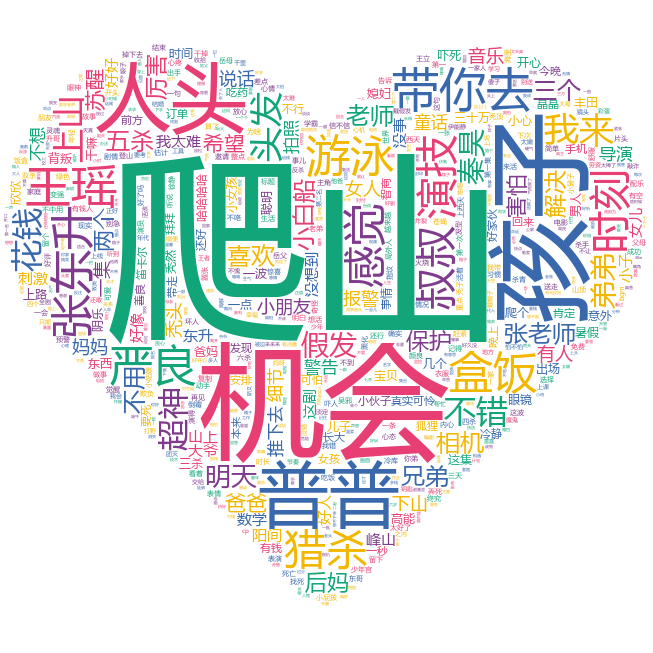

In [28]:
# 绘制词云图
stylecloud.gen_stylecloud(text=' '.join(text1), max_words=1000,
                          collocations=False,
                          font_path=r'‪C:\Windows\Fonts\msyh.ttc',
                          icon_name='fas fa-heart',
                          size=653,
                          output_name='弹幕角色-张东升词云图.png')
Image(filename='弹幕角色-张东升词云图.png') 

### 弹幕角色-朱朝阳 词云图

In [30]:
text2 = get_cut_words(content_series=df_all[df_all.name=='朱朝阳']['content'])
text2[:5]  

['喜欢', '戴燕妮', '哔站', '解说', '二刷']

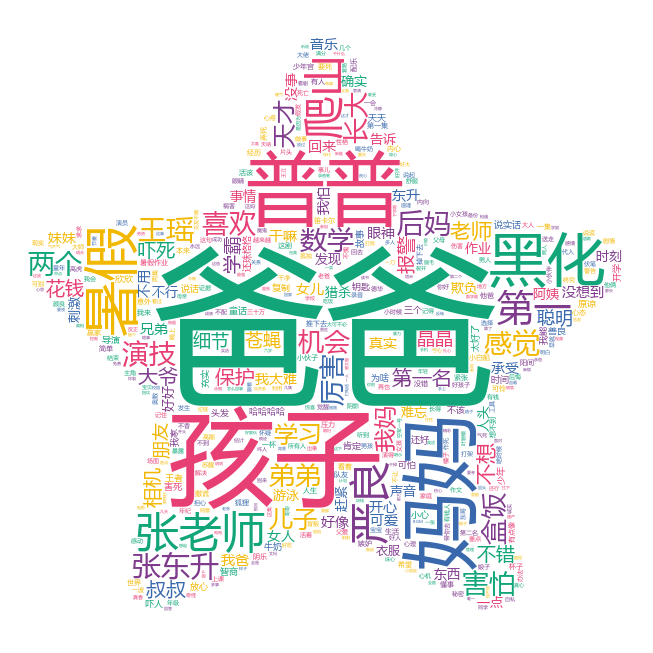

In [31]:
stylecloud.gen_stylecloud(text=' '.join(text2), max_words=1000,
                          collocations=False,
                          font_path=r'‪C:\Windows\Fonts\msyh.ttc',
                          icon_name='fas fa-star',
                          size=653,
                          output_name='弹幕角色-朱朝阳.png')
Image(filename='弹幕角色-朱朝阳.png')  

### 弹幕角色-普普 词云图

In [33]:
text3 = get_cut_words(content_series=df_all[df_all.name=='普普']['content'])
text3[:5]  

['二刷', '朋友', '悠悠', '喜欢', '虞书欣']

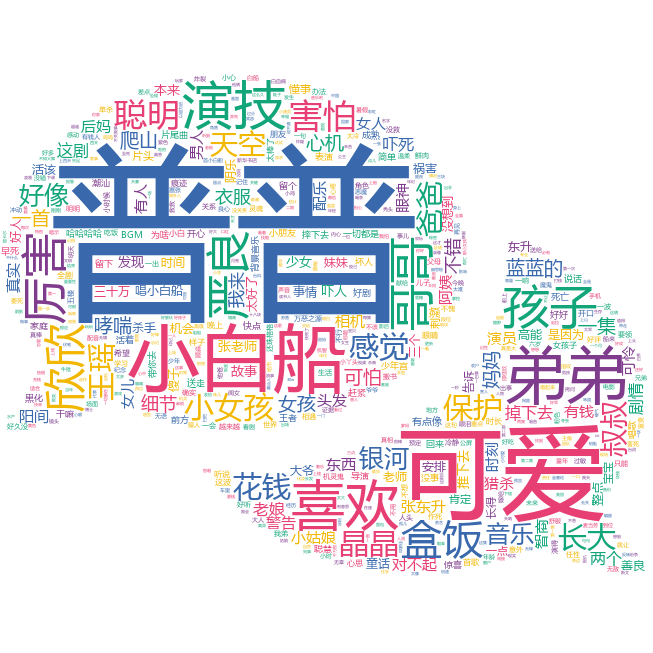

In [34]:
stylecloud.gen_stylecloud(text=' '.join(text3), max_words=1000,
                          collocations=False,
                          font_path=r'‪C:\Windows\Fonts\msyh.ttc',
                          icon_name='fas fa-comments',
                          size=653,
                          output_name='弹幕角色-普普.png')
Image(filename='弹幕角色-普普.png')  

### 弹幕角色-严良 词云图

In [35]:
text4 = get_cut_words(content_series=df_all[df_all.name=='严良']['content'])
text4[:5]  

['八点', '消停', '点儿', '年纪', '高山']

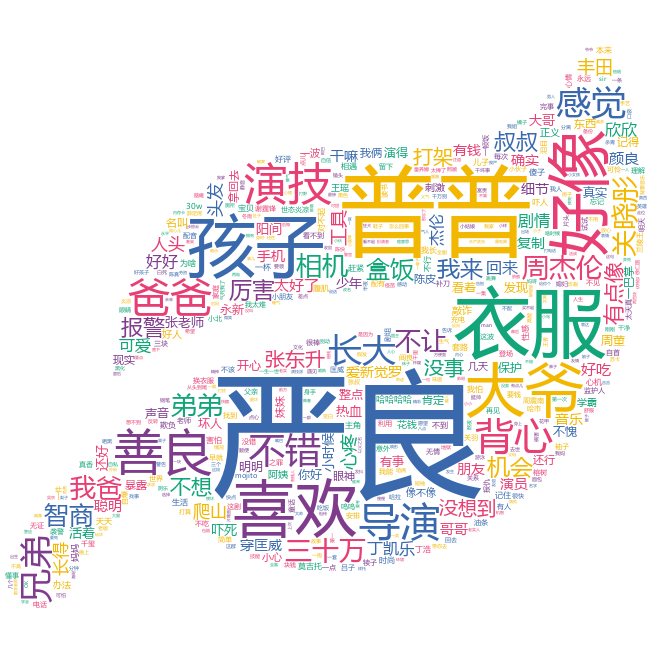

In [40]:
stylecloud.gen_stylecloud(text=' '.join(text4), max_words=1000,
                          collocations=False,
                          font_path=r'‪C:\Windows\Fonts\msyh.ttc',
                          icon_name='fas fa-leaf',
                          size=653,
                          output_name='弹幕角色-严良.png')
Image(filename='弹幕角色-严良.png')  

### 弹幕角色-陈冠声 词云图

In [36]:
text5 = get_cut_words(content_series=df_all[df_all.name=='陈冠声']['content'])
text5[:5] 

['不愧', '影帝', '时长', '害怕', '影帝']

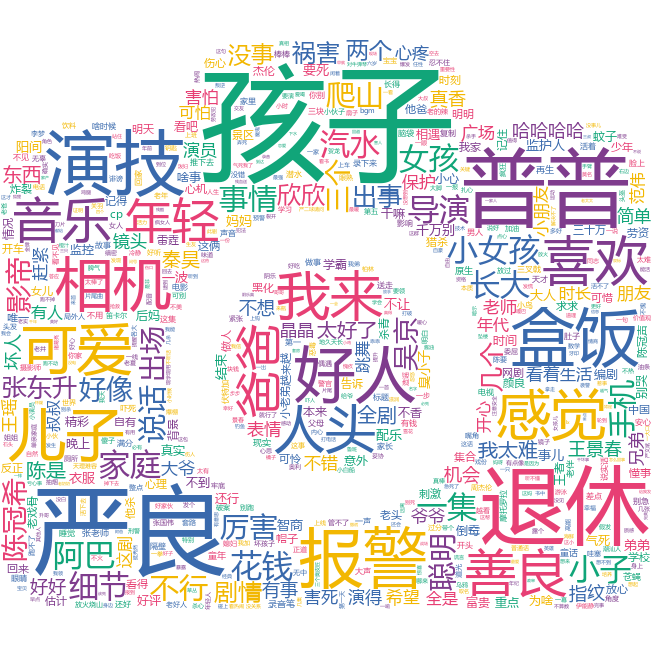

In [37]:
stylecloud.gen_stylecloud(text=' '.join(text5), max_words=1000,
                          collocations=False,
                          font_path=r'‪C:\Windows\Fonts\msyh.ttc',
                          icon_name='fas fa-camera',
                          size=653,
                          output_name='弹幕角色-陈冠声.png')
Image(filename='弹幕角色-陈冠声.png')  

In [38]:
text_all = get_cut_words(df_all.content)
text_all[:5] 

['二刷', '朋友', '良心', '小时', '爬山']

In [39]:
page1 = Page()
page1.add(pie1, bar1, bar2)
page1.render('爱奇艺弹幕数据分析.html')

'd:\\Python\\Mypython\\python项目集锦\\隐秘的角落\\代码\\爱奇艺弹幕数据分析.html'